# Ungraded Lab: Build a Multi-output Model

In this lab, we'll show how you can build models with more than one output. The dataset we will be working on is available from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Energy+efficiency). It is an Energy Efficiency dataset which uses the bulding features (e.g. wall area, roof area) as inputs and has two outputs: Cooling Load and Heating Load. Let's see how we can build a model to train on this data.

## Imports

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import train_test_split

In [9]:
print(tf.__version__)

2.1.0


## Utilities

We define a few utilities for data conversion and visualization to make our code more neat.

In [2]:
def format_output(data):
    y1 = data.pop('Y1')
    y1 = np.array(y1)
    y2 = data.pop('Y2')
    y2 = np.array(y2)
    return y1, y2


def norm(x):
    return (x - train_stats['mean']) / train_stats['std']


def plot_diff(y_true, y_pred, title=''):
    plt.scatter(y_true, y_pred)
    plt.title(title)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    plt.plot([-100, 100], [-100, 100])
    plt.show()


def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0, ylim)
    plt.plot(history.history[metric_name], color='blue', label=metric_name)
    plt.plot(history.history['val_' + metric_name], color='green', label='val_' + metric_name)
    plt.show()

## Prepare the Data

We download the dataset and format it for training.

In [3]:
# Specify data URI
URI = './data/ENB2012_data.xlsx'

# Use pandas excel reader
df = pd.read_excel(URI)
df = df.sample(frac=1).reset_index(drop=True)

# Split the data into train and test with 80 train / 20 test
train, test = train_test_split(df, test_size=0.2)
train_stats = train.describe()

# Get Y1 and Y2 as the 2 outputs and format them as np arrays
train_stats.pop('Y1')
train_stats.pop('Y2')
train_stats = train_stats.transpose()
train_Y = format_output(train)
test_Y = format_output(test)

# Normalize the training and test data
norm_train_X = norm(train)
norm_test_X = norm(test)

## Build the Model

Here is how we'll build the model using the functional syntax. Notice that we can specify a list of outputs (i.e. `[y1_output, y2_output]`) when we instantiate the `Model()` class.

In [4]:
# Define model layers.
input_layer = Input(shape=(len(train .columns),))
first_dense = Dense(units='128', activation='relu')(input_layer)
second_dense = Dense(units='128', activation='relu')(first_dense)

# Y1 output will be fed directly from the second dense
y1_output = Dense(units='1', name='y1_output')(second_dense)
third_dense = Dense(units='64', activation='relu')(second_dense)

# Y2 output will come via the third dense
y2_output = Dense(units='1', name='y2_output')(third_dense)

# Define the model with the input layer and a list of output layers
model = Model(inputs=input_layer, outputs=[y1_output, y2_output])

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          1152        input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          16512       dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 64)           8256        dense_1[0][0]                    
______________________________________________________________________________________________

## Configure parameters

We specify the optimizer as well as the loss and metrics for each output.

In [5]:
# Specify the optimizer, and compile the model with loss functions for both outputs
optimizer = tf.keras.optimizers.SGD(lr=0.001)
model.compile(optimizer=optimizer,
              loss={'y1_output': 'mse', 'y2_output': 'mse'},
              metrics={'y1_output': tf.keras.metrics.RootMeanSquaredError(),
                       'y2_output': tf.keras.metrics.RootMeanSquaredError()})

## Train the Model

In [6]:
# Train the model for 500 epochs
history = model.fit(norm_train_X, train_Y,
                    epochs=500, batch_size=10, validation_data=(norm_test_X, test_Y))

Train on 614 samples, validate on 154 samples
Epoch 1/500
614/614 [==============================] - 1s 980us/sample - loss: 228.3755 - y1_output_loss: 109.6422 - y2_output_loss: 117.6104 - y1_output_root_mean_squared_error: 10.5044 - y2_output_root_mean_squared_error: 10.8643 - val_loss: 99.7371 - val_y1_output_loss: 21.6871 - val_y2_output_loss: 75.4344 - val_y1_output_root_mean_squared_error: 4.7345 - val_y2_output_root_mean_squared_error: 8.7933
Epoch 2/500
614/614 [==============================] - 0s 149us/sample - loss: 30.7875 - y1_output_loss: 12.6402 - y2_output_loss: 18.6566 - y1_output_root_mean_squared_error: 3.5280 - y2_output_root_mean_squared_error: 4.2826 - val_loss: 103.2627 - val_y1_output_loss: 28.4278 - val_y2_output_loss: 75.9939 - val_y1_output_root_mean_squared_error: 5.3427 - val_y2_output_root_mean_squared_error: 8.6440
Epoch 3/500
614/614 [==============================] - 0s 138us/sample - loss: 28.4207 - y1_output_loss: 10.4680 - y2_output_loss: 17.9784 - y

614/614 [==============================] - 0s 141us/sample - loss: 19.8016 - y1_output_loss: 7.0545 - y2_output_loss: 12.7790 - y1_output_root_mean_squared_error: 2.6601 - y2_output_root_mean_squared_error: 3.5673 - val_loss: 24.6468 - val_y1_output_loss: 7.7424 - val_y2_output_loss: 16.0308 - val_y1_output_root_mean_squared_error: 2.8352 - val_y2_output_root_mean_squared_error: 4.0754
Epoch 22/500
614/614 [==============================] - 0s 141us/sample - loss: 25.8221 - y1_output_loss: 7.8065 - y2_output_loss: 17.7984 - y1_output_root_mean_squared_error: 2.8050 - y2_output_root_mean_squared_error: 4.2372 - val_loss: 10.2215 - val_y1_output_loss: 5.0417 - val_y2_output_loss: 5.3085 - val_y1_output_root_mean_squared_error: 2.2621 - val_y2_output_root_mean_squared_error: 2.2593
Epoch 23/500
614/614 [==============================] - 0s 135us/sample - loss: 20.5384 - y1_output_loss: 6.8943 - y2_output_loss: 13.7051 - y1_output_root_mean_squared_error: 2.6272 - y2_output_root_mean_squar

614/614 [==============================] - 0s 130us/sample - loss: 12.1273 - y1_output_loss: 3.8825 - y2_output_loss: 8.1667 - y1_output_root_mean_squared_error: 1.9764 - y2_output_root_mean_squared_error: 2.8672 - val_loss: 10.0473 - val_y1_output_loss: 2.8921 - val_y2_output_loss: 7.7868 - val_y1_output_root_mean_squared_error: 1.6785 - val_y2_output_root_mean_squared_error: 2.6889
Epoch 42/500
614/614 [==============================] - 0s 152us/sample - loss: 9.7604 - y1_output_loss: 2.8449 - y2_output_loss: 6.8964 - y1_output_root_mean_squared_error: 1.6815 - y2_output_root_mean_squared_error: 2.6331 - val_loss: 22.9225 - val_y1_output_loss: 9.0442 - val_y2_output_loss: 14.0289 - val_y1_output_root_mean_squared_error: 3.0168 - val_y2_output_root_mean_squared_error: 3.7178
Epoch 43/500
614/614 [==============================] - 0s 133us/sample - loss: 8.1912 - y1_output_loss: 2.8642 - y2_output_loss: 5.3122 - y1_output_root_mean_squared_error: 1.6900 - y2_output_root_mean_squared_er

Epoch 62/500
614/614 [==============================] - 0s 165us/sample - loss: 6.2330 - y1_output_loss: 1.6366 - y2_output_loss: 4.6309 - y1_output_root_mean_squared_error: 1.2802 - y2_output_root_mean_squared_error: 2.1434 - val_loss: 11.0446 - val_y1_output_loss: 1.4983 - val_y2_output_loss: 9.1650 - val_y1_output_root_mean_squared_error: 1.2397 - val_y2_output_root_mean_squared_error: 3.0835
Epoch 63/500
614/614 [==============================] - 0s 145us/sample - loss: 5.0488 - y1_output_loss: 1.3002 - y2_output_loss: 3.7205 - y1_output_root_mean_squared_error: 1.1433 - y2_output_root_mean_squared_error: 1.9343 - val_loss: 5.2475 - val_y1_output_loss: 1.1540 - val_y2_output_loss: 3.9940 - val_y1_output_root_mean_squared_error: 1.0746 - val_y2_output_root_mean_squared_error: 2.0231
Epoch 64/500
614/614 [==============================] - 0s 131us/sample - loss: 4.1184 - y1_output_loss: 1.2039 - y2_output_loss: 2.9003 - y1_output_root_mean_squared_error: 1.0915 - y2_output_root_mean_

Epoch 83/500
614/614 [==============================] - 0s 132us/sample - loss: 4.1024 - y1_output_loss: 0.9975 - y2_output_loss: 3.1463 - y1_output_root_mean_squared_error: 0.9931 - y2_output_root_mean_squared_error: 1.7653 - val_loss: 8.3813 - val_y1_output_loss: 3.2326 - val_y2_output_loss: 5.0728 - val_y1_output_root_mean_squared_error: 1.8186 - val_y2_output_root_mean_squared_error: 2.2526
Epoch 84/500
614/614 [==============================] - 0s 131us/sample - loss: 4.8496 - y1_output_loss: 1.2736 - y2_output_loss: 3.5573 - y1_output_root_mean_squared_error: 1.1316 - y2_output_root_mean_squared_error: 1.8892 - val_loss: 2.7183 - val_y1_output_loss: 0.7478 - val_y2_output_loss: 2.0268 - val_y1_output_root_mean_squared_error: 0.8719 - val_y2_output_root_mean_squared_error: 1.3993
Epoch 85/500
614/614 [==============================] - 0s 138us/sample - loss: 5.5243 - y1_output_loss: 1.2500 - y2_output_loss: 4.2354 - y1_output_root_mean_squared_error: 1.1221 - y2_output_root_mean_s

Epoch 104/500
614/614 [==============================] - 0s 128us/sample - loss: 3.5060 - y1_output_loss: 0.7866 - y2_output_loss: 2.6964 - y1_output_root_mean_squared_error: 0.8905 - y2_output_root_mean_squared_error: 1.6471 - val_loss: 2.7324 - val_y1_output_loss: 0.7157 - val_y2_output_loss: 2.0446 - val_y1_output_root_mean_squared_error: 0.8550 - val_y2_output_root_mean_squared_error: 1.4147
Epoch 105/500
614/614 [==============================] - 0s 128us/sample - loss: 2.9856 - y1_output_loss: 0.6117 - y2_output_loss: 2.3543 - y1_output_root_mean_squared_error: 0.7851 - y2_output_root_mean_squared_error: 1.5392 - val_loss: 2.7587 - val_y1_output_loss: 0.6036 - val_y2_output_loss: 2.1006 - val_y1_output_root_mean_squared_error: 0.7851 - val_y2_output_root_mean_squared_error: 1.4637
Epoch 106/500
614/614 [==============================] - 0s 137us/sample - loss: 3.4705 - y1_output_loss: 0.8934 - y2_output_loss: 2.5442 - y1_output_root_mean_squared_error: 0.9495 - y2_output_root_mea

614/614 [==============================] - 0s 138us/sample - loss: 2.0155 - y1_output_loss: 0.4369 - y2_output_loss: 1.5883 - y1_output_root_mean_squared_error: 0.6594 - y2_output_root_mean_squared_error: 1.2573 - val_loss: 4.5709 - val_y1_output_loss: 1.4027 - val_y2_output_loss: 3.0716 - val_y1_output_root_mean_squared_error: 1.1971 - val_y2_output_root_mean_squared_error: 1.7714
Epoch 125/500
614/614 [==============================] - 0s 139us/sample - loss: 2.6692 - y1_output_loss: 0.5762 - y2_output_loss: 2.0728 - y1_output_root_mean_squared_error: 0.7613 - y2_output_root_mean_squared_error: 1.4456 - val_loss: 1.8670 - val_y1_output_loss: 0.6679 - val_y2_output_loss: 1.2218 - val_y1_output_root_mean_squared_error: 0.8199 - val_y2_output_root_mean_squared_error: 1.0931
Epoch 126/500
614/614 [==============================] - 0s 135us/sample - loss: 3.4515 - y1_output_loss: 0.6563 - y2_output_loss: 2.7877 - y1_output_root_mean_squared_error: 0.8104 - y2_output_root_mean_squared_erro

Epoch 145/500
614/614 [==============================] - 0s 134us/sample - loss: 1.6619 - y1_output_loss: 0.4143 - y2_output_loss: 1.2503 - y1_output_root_mean_squared_error: 0.6354 - y2_output_root_mean_squared_error: 1.1217 - val_loss: 1.7671 - val_y1_output_loss: 0.5216 - val_y2_output_loss: 1.2566 - val_y1_output_root_mean_squared_error: 0.7305 - val_y2_output_root_mean_squared_error: 1.1106
Epoch 146/500
614/614 [==============================] - 0s 131us/sample - loss: 1.5873 - y1_output_loss: 0.3675 - y2_output_loss: 1.2084 - y1_output_root_mean_squared_error: 0.6075 - y2_output_root_mean_squared_error: 1.1037 - val_loss: 1.7487 - val_y1_output_loss: 0.3364 - val_y2_output_loss: 1.3660 - val_y1_output_root_mean_squared_error: 0.5806 - val_y2_output_root_mean_squared_error: 1.1881
Epoch 147/500
614/614 [==============================] - 0s 142us/sample - loss: 2.0534 - y1_output_loss: 0.5011 - y2_output_loss: 1.5518 - y1_output_root_mean_squared_error: 0.7107 - y2_output_root_mea

614/614 [==============================] - 0s 138us/sample - loss: 1.3211 - y1_output_loss: 0.3075 - y2_output_loss: 1.0476 - y1_output_root_mean_squared_error: 0.5530 - y2_output_root_mean_squared_error: 1.0076 - val_loss: 4.5046 - val_y1_output_loss: 1.3144 - val_y2_output_loss: 3.3783 - val_y1_output_root_mean_squared_error: 1.1314 - val_y2_output_root_mean_squared_error: 1.7957
Epoch 166/500
614/614 [==============================] - 0s 141us/sample - loss: 2.3338 - y1_output_loss: 0.5074 - y2_output_loss: 1.8049 - y1_output_root_mean_squared_error: 0.7156 - y2_output_root_mean_squared_error: 1.3497 - val_loss: 1.2302 - val_y1_output_loss: 0.3097 - val_y2_output_loss: 0.9377 - val_y1_output_root_mean_squared_error: 0.5630 - val_y2_output_root_mean_squared_error: 0.9557
Epoch 167/500
614/614 [==============================] - 0s 141us/sample - loss: 2.4184 - y1_output_loss: 0.4307 - y2_output_loss: 1.9734 - y1_output_root_mean_squared_error: 0.6593 - y2_output_root_mean_squared_erro

Epoch 186/500
614/614 [==============================] - 0s 131us/sample - loss: 2.0905 - y1_output_loss: 0.4767 - y2_output_loss: 1.6258 - y1_output_root_mean_squared_error: 0.6900 - y2_output_root_mean_squared_error: 1.2705 - val_loss: 5.0939 - val_y1_output_loss: 0.6825 - val_y2_output_loss: 4.2824 - val_y1_output_root_mean_squared_error: 0.8365 - val_y2_output_root_mean_squared_error: 2.0962
Epoch 187/500
614/614 [==============================] - 0s 130us/sample - loss: 1.2930 - y1_output_loss: 0.2827 - y2_output_loss: 1.0151 - y1_output_root_mean_squared_error: 0.5301 - y2_output_root_mean_squared_error: 1.0060 - val_loss: 1.7073 - val_y1_output_loss: 0.2430 - val_y2_output_loss: 1.4111 - val_y1_output_root_mean_squared_error: 0.4986 - val_y2_output_root_mean_squared_error: 1.2078
Epoch 188/500
614/614 [==============================] - 0s 128us/sample - loss: 16.6287 - y1_output_loss: 4.5336 - y2_output_loss: 11.9481 - y1_output_root_mean_squared_error: 2.1391 - y2_output_root_m

614/614 [==============================] - 0s 134us/sample - loss: 2.0706 - y1_output_loss: 0.3577 - y2_output_loss: 1.6984 - y1_output_root_mean_squared_error: 0.5993 - y2_output_root_mean_squared_error: 1.3082 - val_loss: 1.7495 - val_y1_output_loss: 0.2418 - val_y2_output_loss: 1.4527 - val_y1_output_root_mean_squared_error: 0.4985 - val_y2_output_root_mean_squared_error: 1.2251
Epoch 207/500
614/614 [==============================] - 0s 137us/sample - loss: 1.8318 - y1_output_loss: 0.3621 - y2_output_loss: 1.4574 - y1_output_root_mean_squared_error: 0.6042 - y2_output_root_mean_squared_error: 1.2111 - val_loss: 1.7445 - val_y1_output_loss: 0.5070 - val_y2_output_loss: 1.2022 - val_y1_output_root_mean_squared_error: 0.7171 - val_y2_output_root_mean_squared_error: 1.1092
Epoch 208/500
614/614 [==============================] - 0s 137us/sample - loss: 1.1532 - y1_output_loss: 0.2316 - y2_output_loss: 0.9248 - y1_output_root_mean_squared_error: 0.4780 - y2_output_root_mean_squared_erro

Epoch 227/500
614/614 [==============================] - 0s 136us/sample - loss: 1.0220 - y1_output_loss: 0.2395 - y2_output_loss: 0.7883 - y1_output_root_mean_squared_error: 0.4887 - y2_output_root_mean_squared_error: 0.8850 - val_loss: 4.7608 - val_y1_output_loss: 0.9841 - val_y2_output_loss: 3.6556 - val_y1_output_root_mean_squared_error: 1.0069 - val_y2_output_root_mean_squared_error: 1.9357
Epoch 228/500
614/614 [==============================] - 0s 138us/sample - loss: 1.2651 - y1_output_loss: 0.2806 - y2_output_loss: 0.9942 - y1_output_root_mean_squared_error: 0.5278 - y2_output_root_mean_squared_error: 0.9932 - val_loss: 2.6569 - val_y1_output_loss: 0.5510 - val_y2_output_loss: 2.1151 - val_y1_output_root_mean_squared_error: 0.7479 - val_y2_output_root_mean_squared_error: 1.4483
Epoch 229/500
614/614 [==============================] - 0s 139us/sample - loss: 2.5432 - y1_output_loss: 0.6543 - y2_output_loss: 1.9159 - y1_output_root_mean_squared_error: 0.8090 - y2_output_root_mea

614/614 [==============================] - 0s 130us/sample - loss: 1.1946 - y1_output_loss: 0.2544 - y2_output_loss: 0.9331 - y1_output_root_mean_squared_error: 0.5056 - y2_output_root_mean_squared_error: 0.9690 - val_loss: 1.4578 - val_y1_output_loss: 0.2983 - val_y2_output_loss: 1.1109 - val_y1_output_root_mean_squared_error: 0.5534 - val_y2_output_root_mean_squared_error: 1.0731
Epoch 248/500
614/614 [==============================] - 0s 152us/sample - loss: 1.0795 - y1_output_loss: 0.2366 - y2_output_loss: 0.8639 - y1_output_root_mean_squared_error: 0.4771 - y2_output_root_mean_squared_error: 0.9230 - val_loss: 5.6726 - val_y1_output_loss: 1.4507 - val_y2_output_loss: 4.0730 - val_y1_output_root_mean_squared_error: 1.2243 - val_y2_output_root_mean_squared_error: 2.0430
Epoch 249/500
614/614 [==============================] - 0s 143us/sample - loss: 1.1089 - y1_output_loss: 0.2484 - y2_output_loss: 0.8646 - y1_output_root_mean_squared_error: 0.4959 - y2_output_root_mean_squared_erro

Epoch 268/500
614/614 [==============================] - 0s 133us/sample - loss: 0.9866 - y1_output_loss: 0.1905 - y2_output_loss: 0.8119 - y1_output_root_mean_squared_error: 0.4346 - y2_output_root_mean_squared_error: 0.8932 - val_loss: 2.1797 - val_y1_output_loss: 0.6148 - val_y2_output_loss: 1.6361 - val_y1_output_root_mean_squared_error: 0.7760 - val_y2_output_root_mean_squared_error: 1.2560
Epoch 269/500
614/614 [==============================] - 0s 132us/sample - loss: 1.0144 - y1_output_loss: 0.2263 - y2_output_loss: 0.7953 - y1_output_root_mean_squared_error: 0.4745 - y2_output_root_mean_squared_error: 0.8884 - val_loss: 2.2380 - val_y1_output_loss: 0.4466 - val_y2_output_loss: 1.7215 - val_y1_output_root_mean_squared_error: 0.6806 - val_y2_output_root_mean_squared_error: 1.3322
Epoch 270/500
614/614 [==============================] - 0s 135us/sample - loss: 0.8514 - y1_output_loss: 0.2009 - y2_output_loss: 0.6446 - y1_output_root_mean_squared_error: 0.4483 - y2_output_root_mea

614/614 [==============================] - 0s 138us/sample - loss: 0.9295 - y1_output_loss: 0.2222 - y2_output_loss: 0.7131 - y1_output_root_mean_squared_error: 0.4695 - y2_output_root_mean_squared_error: 0.8421 - val_loss: 2.4506 - val_y1_output_loss: 0.8470 - val_y2_output_loss: 1.5629 - val_y1_output_root_mean_squared_error: 0.9296 - val_y2_output_root_mean_squared_error: 1.2595
Epoch 289/500
614/614 [==============================] - 0s 137us/sample - loss: 1.0010 - y1_output_loss: 0.2217 - y2_output_loss: 0.7708 - y1_output_root_mean_squared_error: 0.4727 - y2_output_root_mean_squared_error: 0.8818 - val_loss: 0.8988 - val_y1_output_loss: 0.1943 - val_y2_output_loss: 0.6781 - val_y1_output_root_mean_squared_error: 0.4491 - val_y2_output_root_mean_squared_error: 0.8349
Epoch 290/500
614/614 [==============================] - 0s 136us/sample - loss: 0.8399 - y1_output_loss: 0.1903 - y2_output_loss: 0.6442 - y1_output_root_mean_squared_error: 0.4365 - y2_output_root_mean_squared_erro

Epoch 309/500
614/614 [==============================] - 0s 129us/sample - loss: 0.6492 - y1_output_loss: 0.1675 - y2_output_loss: 0.4774 - y1_output_root_mean_squared_error: 0.4095 - y2_output_root_mean_squared_error: 0.6939 - val_loss: 0.7400 - val_y1_output_loss: 0.1892 - val_y2_output_loss: 0.5389 - val_y1_output_root_mean_squared_error: 0.4404 - val_y2_output_root_mean_squared_error: 0.7389
Epoch 310/500
614/614 [==============================] - 0s 130us/sample - loss: 0.7116 - y1_output_loss: 0.1660 - y2_output_loss: 0.5458 - y1_output_root_mean_squared_error: 0.4086 - y2_output_root_mean_squared_error: 0.7380 - val_loss: 1.1497 - val_y1_output_loss: 0.1730 - val_y2_output_loss: 0.9468 - val_y1_output_root_mean_squared_error: 0.4236 - val_y2_output_root_mean_squared_error: 0.9850
Epoch 311/500
614/614 [==============================] - 0s 131us/sample - loss: 0.5985 - y1_output_loss: 0.1507 - y2_output_loss: 0.4449 - y1_output_root_mean_squared_error: 0.3875 - y2_output_root_mea

614/614 [==============================] - 0s 135us/sample - loss: 0.8956 - y1_output_loss: 0.1887 - y2_output_loss: 0.7003 - y1_output_root_mean_squared_error: 0.4353 - y2_output_root_mean_squared_error: 0.8403 - val_loss: 0.9112 - val_y1_output_loss: 0.2607 - val_y2_output_loss: 0.6495 - val_y1_output_root_mean_squared_error: 0.5127 - val_y2_output_root_mean_squared_error: 0.8052
Epoch 330/500
614/614 [==============================] - 0s 135us/sample - loss: 0.6700 - y1_output_loss: 0.1728 - y2_output_loss: 0.5098 - y1_output_root_mean_squared_error: 0.4170 - y2_output_root_mean_squared_error: 0.7043 - val_loss: 3.1135 - val_y1_output_loss: 0.2163 - val_y2_output_loss: 2.9433 - val_y1_output_root_mean_squared_error: 0.4696 - val_y2_output_root_mean_squared_error: 1.7009
Epoch 331/500
614/614 [==============================] - 0s 133us/sample - loss: 0.8733 - y1_output_loss: 0.1798 - y2_output_loss: 0.6919 - y1_output_root_mean_squared_error: 0.4247 - y2_output_root_mean_squared_erro

Epoch 350/500
614/614 [==============================] - 0s 134us/sample - loss: 0.6206 - y1_output_loss: 0.1761 - y2_output_loss: 0.4399 - y1_output_root_mean_squared_error: 0.4212 - y2_output_root_mean_squared_error: 0.6657 - val_loss: 0.8075 - val_y1_output_loss: 0.1938 - val_y2_output_loss: 0.5858 - val_y1_output_root_mean_squared_error: 0.4482 - val_y2_output_root_mean_squared_error: 0.7788
Epoch 351/500
614/614 [==============================] - 0s 139us/sample - loss: 0.9130 - y1_output_loss: 0.1862 - y2_output_loss: 0.7194 - y1_output_root_mean_squared_error: 0.4329 - y2_output_root_mean_squared_error: 0.8518 - val_loss: 0.8945 - val_y1_output_loss: 0.2330 - val_y2_output_loss: 0.6474 - val_y1_output_root_mean_squared_error: 0.4848 - val_y2_output_root_mean_squared_error: 0.8121
Epoch 352/500
614/614 [==============================] - 0s 139us/sample - loss: 0.5703 - y1_output_loss: 0.1537 - y2_output_loss: 0.4137 - y1_output_root_mean_squared_error: 0.3926 - y2_output_root_mea

614/614 [==============================] - 0s 131us/sample - loss: 0.5006 - y1_output_loss: 0.1495 - y2_output_loss: 0.3474 - y1_output_root_mean_squared_error: 0.3872 - y2_output_root_mean_squared_error: 0.5922 - val_loss: 0.7664 - val_y1_output_loss: 0.1860 - val_y2_output_loss: 0.5544 - val_y1_output_root_mean_squared_error: 0.4382 - val_y2_output_root_mean_squared_error: 0.7579
Epoch 371/500
614/614 [==============================] - 0s 131us/sample - loss: 0.6254 - y1_output_loss: 0.1774 - y2_output_loss: 0.4489 - y1_output_root_mean_squared_error: 0.4227 - y2_output_root_mean_squared_error: 0.6684 - val_loss: 0.9638 - val_y1_output_loss: 0.1958 - val_y2_output_loss: 0.7579 - val_y1_output_root_mean_squared_error: 0.4486 - val_y2_output_root_mean_squared_error: 0.8732
Epoch 372/500
614/614 [==============================] - 0s 131us/sample - loss: 0.6881 - y1_output_loss: 0.1789 - y2_output_loss: 0.5066 - y1_output_root_mean_squared_error: 0.4226 - y2_output_root_mean_squared_erro

Epoch 391/500
614/614 [==============================] - 0s 136us/sample - loss: 0.6600 - y1_output_loss: 0.1635 - y2_output_loss: 0.4921 - y1_output_root_mean_squared_error: 0.4056 - y2_output_root_mean_squared_error: 0.7039 - val_loss: 0.7296 - val_y1_output_loss: 0.1878 - val_y2_output_loss: 0.5183 - val_y1_output_root_mean_squared_error: 0.4395 - val_y2_output_root_mean_squared_error: 0.7324
Epoch 392/500
614/614 [==============================] - 0s 138us/sample - loss: 0.5940 - y1_output_loss: 0.1559 - y2_output_loss: 0.4368 - y1_output_root_mean_squared_error: 0.3964 - y2_output_root_mean_squared_error: 0.6610 - val_loss: 0.7605 - val_y1_output_loss: 0.1976 - val_y2_output_loss: 0.5514 - val_y1_output_root_mean_squared_error: 0.4507 - val_y2_output_root_mean_squared_error: 0.7466
Epoch 393/500
614/614 [==============================] - 0s 130us/sample - loss: 0.6629 - y1_output_loss: 0.1551 - y2_output_loss: 0.5049 - y1_output_root_mean_squared_error: 0.3942 - y2_output_root_mea

614/614 [==============================] - 0s 129us/sample - loss: 0.5166 - y1_output_loss: 0.1462 - y2_output_loss: 0.3688 - y1_output_root_mean_squared_error: 0.3802 - y2_output_root_mean_squared_error: 0.6099 - val_loss: 0.6206 - val_y1_output_loss: 0.1794 - val_y2_output_loss: 0.4228 - val_y1_output_root_mean_squared_error: 0.4306 - val_y2_output_root_mean_squared_error: 0.6597
Epoch 412/500
614/614 [==============================] - 0s 138us/sample - loss: 0.6310 - y1_output_loss: 0.1764 - y2_output_loss: 0.4535 - y1_output_root_mean_squared_error: 0.4201 - y2_output_root_mean_squared_error: 0.6741 - val_loss: 0.7734 - val_y1_output_loss: 0.1751 - val_y2_output_loss: 0.5906 - val_y1_output_root_mean_squared_error: 0.4260 - val_y2_output_root_mean_squared_error: 0.7694
Epoch 413/500
614/614 [==============================] - 0s 140us/sample - loss: 0.3891 - y1_output_loss: 0.1270 - y2_output_loss: 0.2605 - y1_output_root_mean_squared_error: 0.3573 - y2_output_root_mean_squared_erro

Epoch 432/500
614/614 [==============================] - 0s 131us/sample - loss: 0.4780 - y1_output_loss: 0.1365 - y2_output_loss: 0.3508 - y1_output_root_mean_squared_error: 0.3697 - y2_output_root_mean_squared_error: 0.5843 - val_loss: 1.4966 - val_y1_output_loss: 0.1871 - val_y2_output_loss: 1.2730 - val_y1_output_root_mean_squared_error: 0.4391 - val_y2_output_root_mean_squared_error: 1.1418
Epoch 433/500
614/614 [==============================] - 0s 130us/sample - loss: 0.5842 - y1_output_loss: 0.1625 - y2_output_loss: 0.4201 - y1_output_root_mean_squared_error: 0.4043 - y2_output_root_mean_squared_error: 0.6487 - val_loss: 0.8612 - val_y1_output_loss: 0.2352 - val_y2_output_loss: 0.6258 - val_y1_output_root_mean_squared_error: 0.4878 - val_y2_output_root_mean_squared_error: 0.7895
Epoch 434/500
614/614 [==============================] - 0s 142us/sample - loss: 0.5380 - y1_output_loss: 0.1548 - y2_output_loss: 0.3854 - y1_output_root_mean_squared_error: 0.3940 - y2_output_root_mea

614/614 [==============================] - 0s 148us/sample - loss: 0.4698 - y1_output_loss: 0.1385 - y2_output_loss: 0.3324 - y1_output_root_mean_squared_error: 0.3719 - y2_output_root_mean_squared_error: 0.5758 - val_loss: 0.9196 - val_y1_output_loss: 0.2279 - val_y2_output_loss: 0.6994 - val_y1_output_root_mean_squared_error: 0.4825 - val_y2_output_root_mean_squared_error: 0.8287
Epoch 453/500
614/614 [==============================] - 0s 131us/sample - loss: 0.4893 - y1_output_loss: 0.1556 - y2_output_loss: 0.3432 - y1_output_root_mean_squared_error: 0.3786 - y2_output_root_mean_squared_error: 0.5882 - val_loss: 0.8641 - val_y1_output_loss: 0.3552 - val_y2_output_loss: 0.4818 - val_y1_output_root_mean_squared_error: 0.6040 - val_y2_output_root_mean_squared_error: 0.7066
Epoch 454/500
614/614 [==============================] - 0s 132us/sample - loss: 0.3827 - y1_output_loss: 0.1223 - y2_output_loss: 0.2607 - y1_output_root_mean_squared_error: 0.3503 - y2_output_root_mean_squared_erro

Epoch 473/500
614/614 [==============================] - 0s 130us/sample - loss: 0.4967 - y1_output_loss: 0.1416 - y2_output_loss: 0.3520 - y1_output_root_mean_squared_error: 0.3767 - y2_output_root_mean_squared_error: 0.5957 - val_loss: 0.6809 - val_y1_output_loss: 0.2166 - val_y2_output_loss: 0.4426 - val_y1_output_root_mean_squared_error: 0.4721 - val_y2_output_root_mean_squared_error: 0.6768
Epoch 474/500
614/614 [==============================] - 0s 136us/sample - loss: 0.4851 - y1_output_loss: 0.1241 - y2_output_loss: 0.3631 - y1_output_root_mean_squared_error: 0.3506 - y2_output_root_mean_squared_error: 0.6018 - val_loss: 2.1607 - val_y1_output_loss: 0.3891 - val_y2_output_loss: 1.7233 - val_y1_output_root_mean_squared_error: 0.6352 - val_y2_output_root_mean_squared_error: 1.3256
Epoch 475/500
614/614 [==============================] - 0s 132us/sample - loss: 0.4693 - y1_output_loss: 0.1317 - y2_output_loss: 0.3350 - y1_output_root_mean_squared_error: 0.3640 - y2_output_root_mea

614/614 [==============================] - 0s 141us/sample - loss: 0.4003 - y1_output_loss: 0.1261 - y2_output_loss: 0.2730 - y1_output_root_mean_squared_error: 0.3552 - y2_output_root_mean_squared_error: 0.5236 - val_loss: 0.6059 - val_y1_output_loss: 0.1637 - val_y2_output_loss: 0.4328 - val_y1_output_root_mean_squared_error: 0.4100 - val_y2_output_root_mean_squared_error: 0.6617
Epoch 494/500
614/614 [==============================] - 0s 137us/sample - loss: 0.3482 - y1_output_loss: 0.1208 - y2_output_loss: 0.2257 - y1_output_root_mean_squared_error: 0.3487 - y2_output_root_mean_squared_error: 0.4760 - val_loss: 0.5796 - val_y1_output_loss: 0.1591 - val_y2_output_loss: 0.4076 - val_y1_output_root_mean_squared_error: 0.4055 - val_y2_output_root_mean_squared_error: 0.6443
Epoch 495/500
614/614 [==============================] - 0s 128us/sample - loss: 0.3359 - y1_output_loss: 0.1160 - y2_output_loss: 0.2186 - y1_output_root_mean_squared_error: 0.3404 - y2_output_root_mean_squared_erro

## Evaluate the Model and Plot Metrics

In [7]:
# Test the model and print loss and mse for both outputs
loss, Y1_loss, Y2_loss, Y1_rmse, Y2_rmse = model.evaluate(x=norm_test_X, y=test_Y)
print("Loss = {}, Y1_loss = {}, Y1_mse = {}, Y2_loss = {}, Y2_mse = {}".format(loss, Y1_loss, Y1_rmse, Y2_loss, Y2_rmse))

154/154 [==============================] - 0s 41us/sample - loss: 0.9584 - y1_output_loss: 0.2218 - y2_output_loss: 0.7348 - y1_output_root_mean_squared_error: 0.4696 - y2_output_root_mean_squared_error: 0.8590
Loss = 0.9584471653034161, Y1_loss = 0.2217698097229004, Y1_mse = 0.469630628824234, Y2_loss = 0.734765350818634, Y2_mse = 0.859007716178894


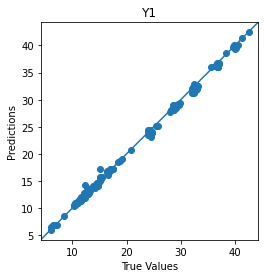

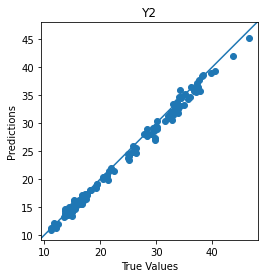

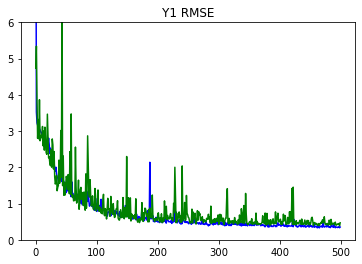

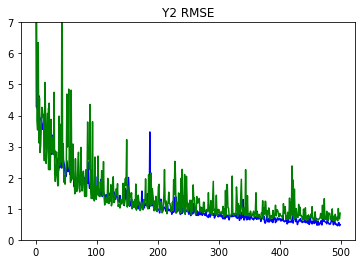

In [8]:
# Plot the loss and mse
Y_pred = model.predict(norm_test_X)
plot_diff(test_Y[0], Y_pred[0], title='Y1')
plot_diff(test_Y[1], Y_pred[1], title='Y2')
plot_metrics(metric_name='y1_output_root_mean_squared_error', title='Y1 RMSE', ylim=6)
plot_metrics(metric_name='y2_output_root_mean_squared_error', title='Y2 RMSE', ylim=7)